In [3]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, skew
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('BankChurners.csv')

In [5]:
NbVarQualitative = 0 
NbVarQuantitative = 0

numerical_columns = []
object_columns = []

for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        NbVarQuantitative += 1
        numerical_columns.append(col)
    else:
        NbVarQualitative += 1
        object_columns.append(col)

print(f"Nombre de variables quantitatives : {NbVarQuantitative}")
print("Colonnes quantitatives :", numerical_columns)

print(f"\nNombre de variables qualitatives : {NbVarQualitative}")
print("Colonnes qualitatives :", object_columns)

Nombre de variables quantitatives : 17
Colonnes quantitatives : ['CLIENTNUM', 'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

Nombre de variables qualitatives : 6
Colonnes qualitatives : ['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


Précision : 1.000


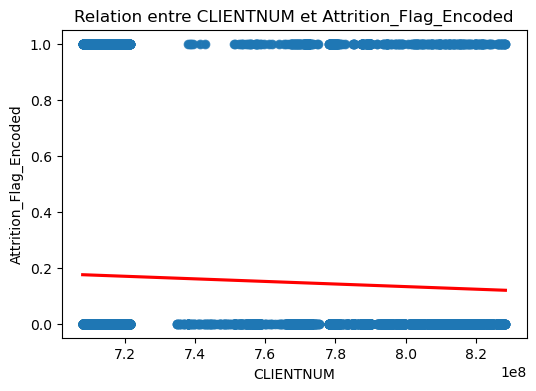

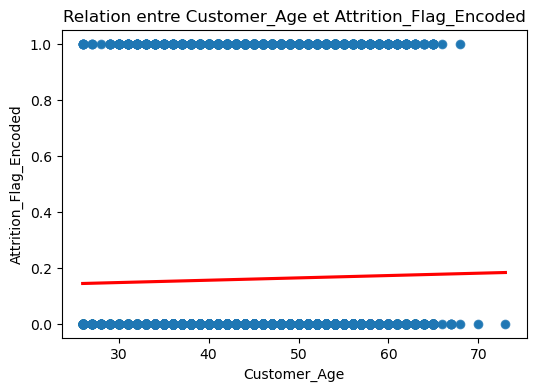

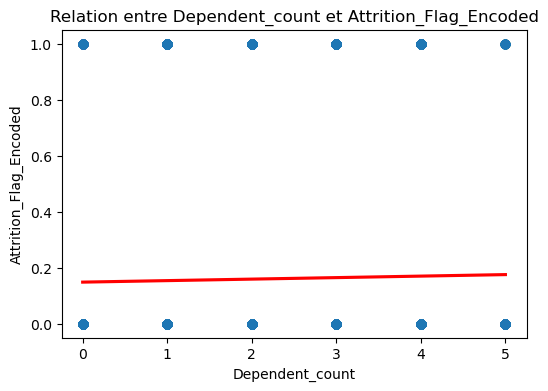

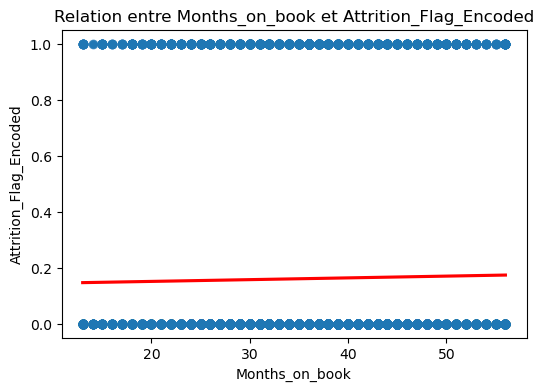

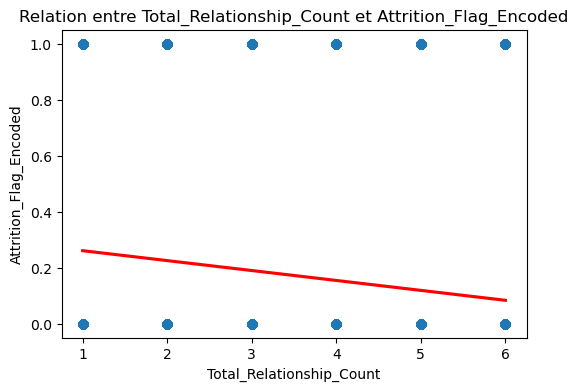

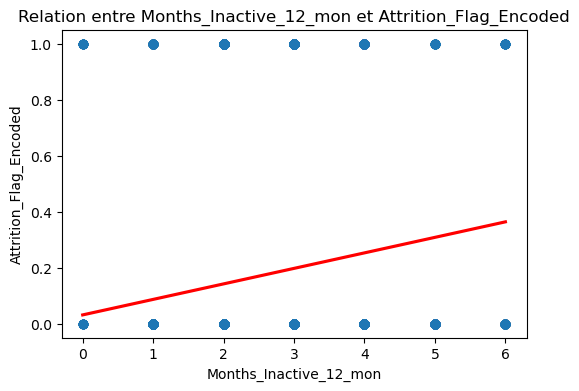

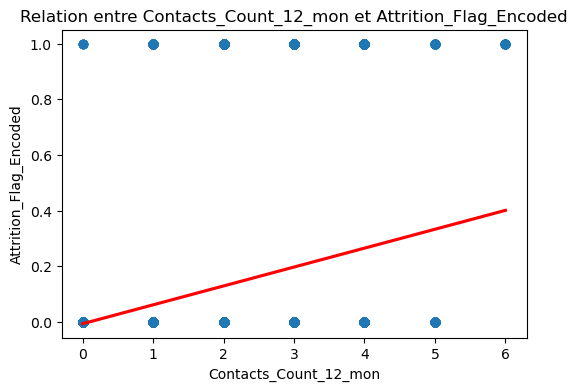

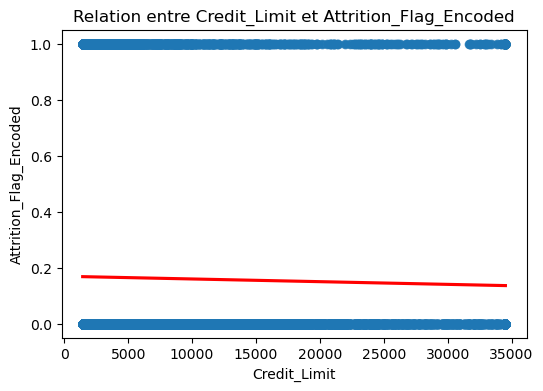

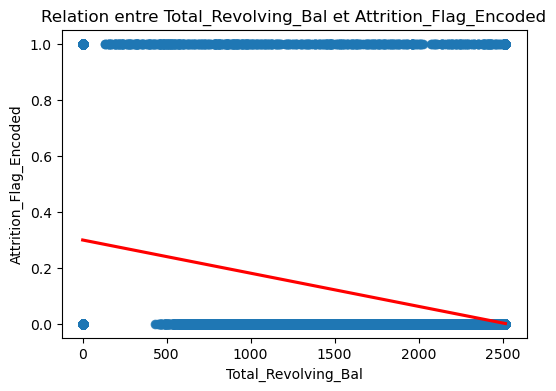

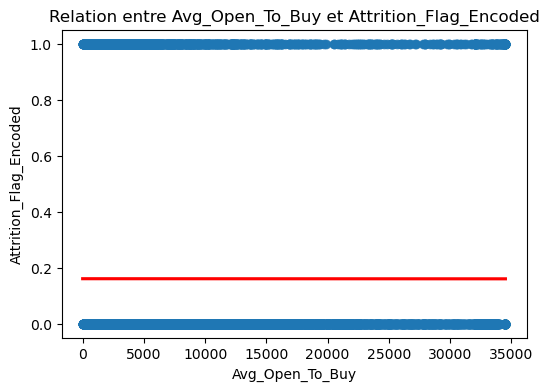

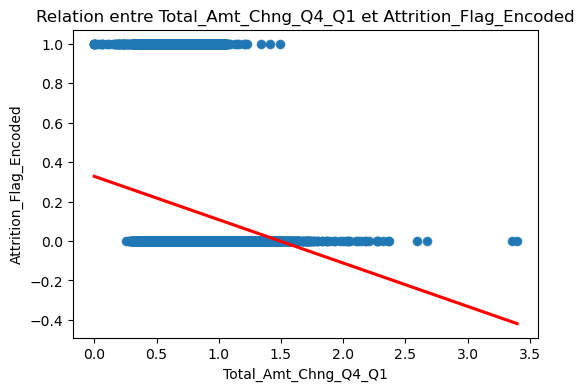

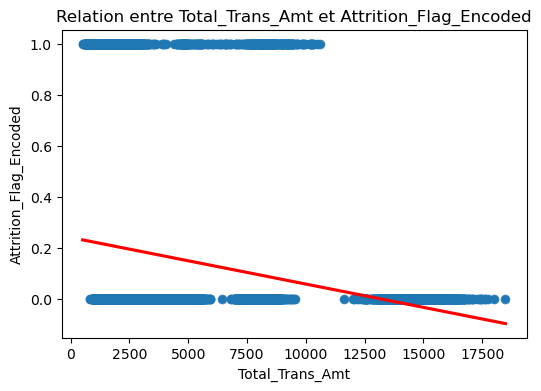

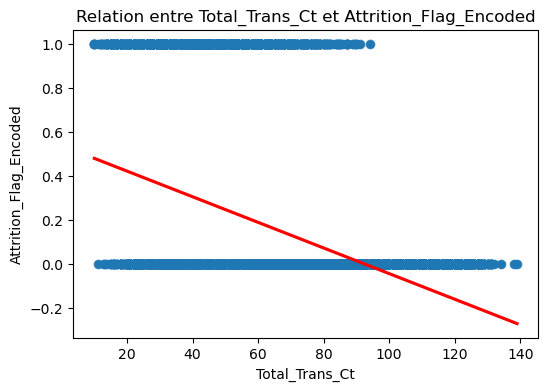

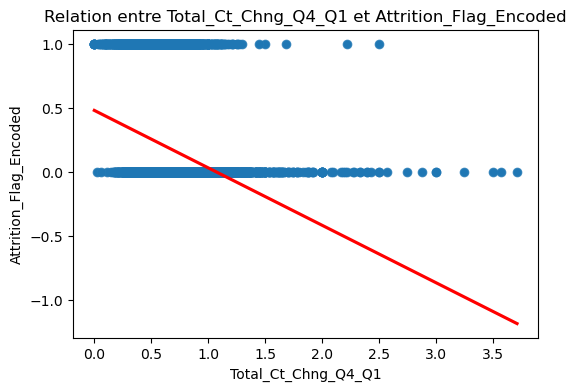

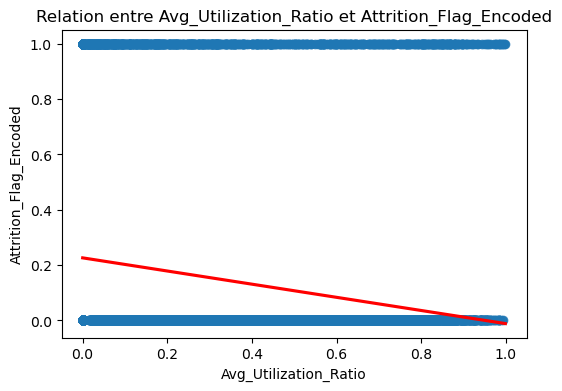

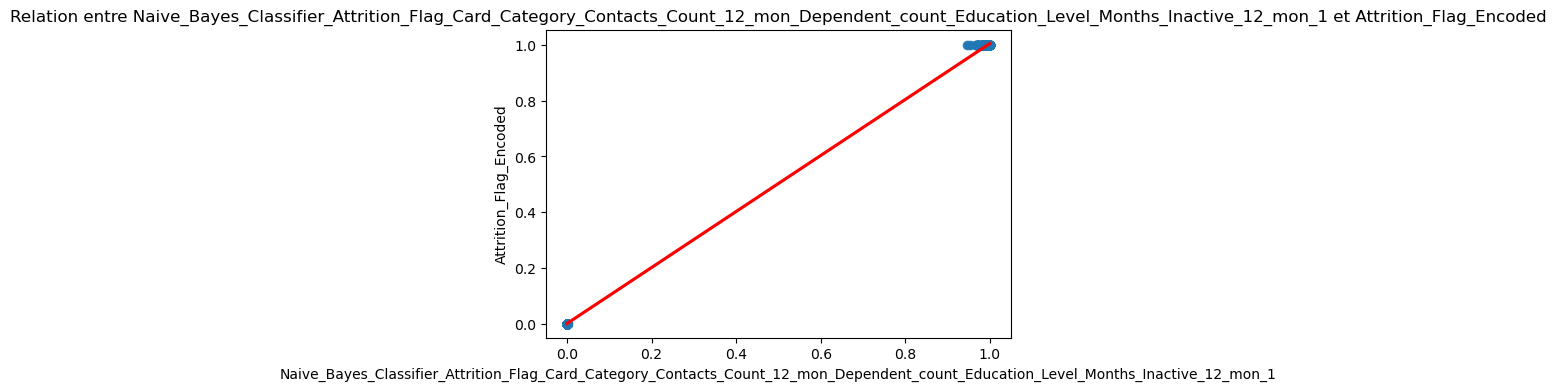

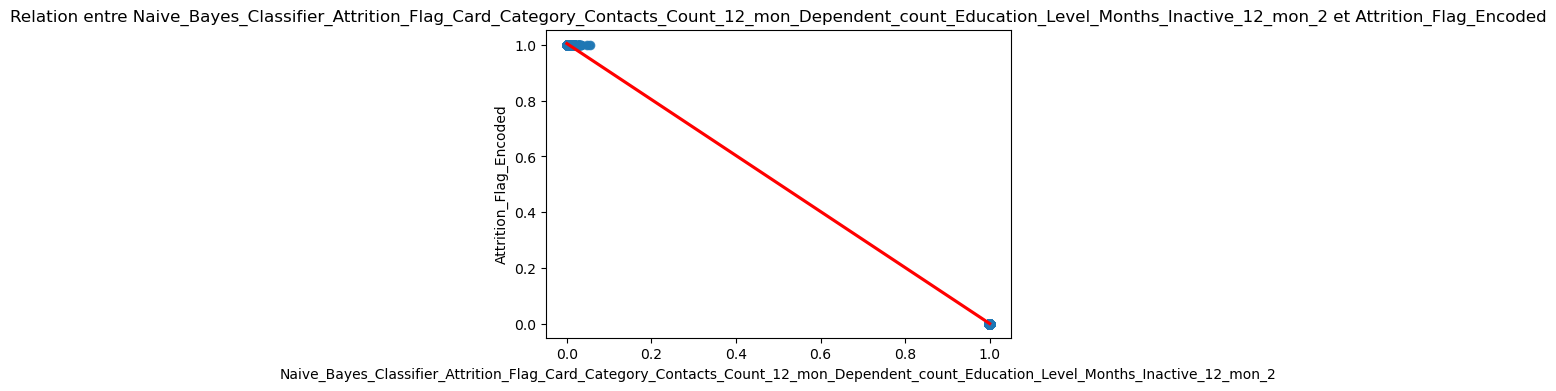

In [13]:
df['Attrition_Flag_Encoded'] = (df['Attrition_Flag'] == 'Attrited Customer').astype(int)
from sklearn.metrics import precision_score

y_true = df['Attrition_Flag_Encoded']  # valeurs 0 ou 1
y_pred_prob = df['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1']

# Convertir probabilités en prédictions binaires
y_pred = (y_pred_prob >= 0.5).astype(int)

precision = precision_score(y_true, y_pred)
print(f"Précision : {precision:.3f}")
import seaborn as sns
import matplotlib.pyplot as plt

target = 'Attrition_Flag_Encoded'  # nom de ta variable cible

# Boucle sur toutes les colonnes sauf la cible
for col in df.columns:
    if col != target and pd.api.types.is_numeric_dtype(df[col]):
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=df[col], y=df[target])
        sns.regplot(x=df[col], y=df[target], ci=None, line_kws={"color": "red"})
        plt.title(f"Relation entre {col} et {target}")
        plt.show()


In [420]:
corr_vars = [
    'Customer_Age', 'Dependent_count', 'Months_on_book', 'Months_Inactive_12_mon',
    'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy',
    'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
    'Total_Relationship_Count', 'Avg_Utilization_Ratio', 'Attrition_Flag_Encoded'
]

# Calcul et affichage de la matrice de corrélation
corr_matrix = df[corr_vars].corr()
print("Correlation Matrix:")
print(corr_matrix)

# Visualisation de la matrice de corrélation
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.close()

Correlation Matrix:
                          Customer_Age  Dependent_count  Months_on_book  \
Customer_Age                  1.000000        -0.122254        0.788912   
Dependent_count              -0.122254         1.000000       -0.103062   
Months_on_book                0.788912        -0.103062        1.000000   
Months_Inactive_12_mon        0.054361        -0.010768        0.074164   
Contacts_Count_12_mon        -0.018452        -0.040505       -0.010774   
Credit_Limit                  0.002476         0.068065        0.007507   
Total_Revolving_Bal           0.014780        -0.002688        0.008623   
Avg_Open_To_Buy               0.001151         0.068291        0.006732   
Total_Amt_Chng_Q4_Q1         -0.062042        -0.035439       -0.048959   
Total_Trans_Amt              -0.046446         0.025046       -0.038591   
Total_Trans_Ct               -0.067097         0.049912       -0.049819   
Total_Ct_Chng_Q4_Q1          -0.012143         0.011087       -0.014072   
Total

In [421]:
df_model = df.drop(['CLIENTNUM', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 
                    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
                    'Attrition_Flag','Months_on_book' , 'Avg_Open_To_Buy' , 'Total_Trans_Amt'],  axis=1) 
df_model = df_model[df_model['Income_Category'] != 'Unknown']

In [422]:
import pandas as pd
from scipy.stats import chi2_contingency

# Sélection initiale des colonnes qualitatives et numériques
cat_cols = df_model.select_dtypes(include=['object']).columns.tolist()
num_cols = df_model.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols.remove('Attrition_Flag_Encoded')  # Retirer la variable cible

# Vérification des colonnes initiales
print(f"Colonnes qualitatives initiales : {cat_cols}")

# Sélection des variables qualitatives pertinentes avec test chi-carré
significant_cat_cols = []
for var in cat_cols:
    contingency_table = pd.crosstab(df_model[var], df_model['Attrition_Flag_Encoded'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Test chi-carré pour {var}: p-value = {p:.4f}")
    if p < 0.05:  # Seuil de significativité
        significant_cat_cols.append(var)
print(f"Variables qualitatives significatives (p < 0.05) : {significant_cat_cols}")

# Encodage des variables qualitatives significatives avec one-hot encoding
if significant_cat_cols:
    df_model = pd.get_dummies(df_model, columns=significant_cat_cols, dummy_na=False)  # Réassignation directe
    print(f"Colonnes après encodage : {df_model.columns.tolist()}")
else:
    print("Aucune variable qualitative significative à encoder.")

# Conversion des colonnes encodées en type int64 (uniquement si encodage effectué)
for column in df_model.columns:
    if column not in num_cols and column != 'Attrition_Flag_Encoded':  # Cible les nouvelles colonnes encodées
        if df_model[column].dtype != 'int64':  # Vérifie si la colonne n'est pas déjà int64
            try:
                df_model[column] = df_model[column].astype('int64')
                print(f"Conversion réussie pour {column}")
            except ValueError as e:
                print(f"Erreur de conversion pour {column}: {e}")

# Mettre à jour num_cols avec toutes les colonnes numériques, y compris les encodées
num_cols = df_model.select_dtypes(include=['int64', 'float64']).columns.tolist()  # Maintenant toutes en int64 ou float64
num_cols.remove('Attrition_Flag_Encoded')  # Réassurer que la cible est exclue

# Afficher le nombre total de colonnes numériques après encodage et conversion
print(f"Nombre total de colonnes numériques après encodage : {len(num_cols)}")
print(f"Colonnes incluses : {num_cols}")
print(f"Types de données : \n{df_model.dtypes}")

Colonnes qualitatives initiales : ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
Test chi-carré pour Gender: p-value = 0.0004
Test chi-carré pour Education_Level: p-value = 0.0540
Test chi-carré pour Marital_Status: p-value = 0.1614
Test chi-carré pour Income_Category: p-value = 0.0148
Test chi-carré pour Card_Category: p-value = 0.8398
Variables qualitatives significatives (p < 0.05) : ['Gender', 'Income_Category']
Colonnes après encodage : ['Customer_Age', 'Dependent_count', 'Education_Level', 'Marital_Status', 'Card_Category', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Attrition_Flag_Encoded', 'Gender_F', 'Gender_M', 'Income_Category_$120K +', 'Income_Category_$40K - $60K', 'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K', 'Income_Category_Less than $40K']
Erreur de conv

In [426]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split

# 16. Analyse factorielle (ACP et AFD)

# Standardisation des données numériques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_model[num_cols])

# --- Partie 1 : ACP ---
# Application de l'ACP
pca = PCA(random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Calcul de la variance expliquée
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Détermination du nombre optimal de composantes
n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
print(f"\nNombre de composantes pour 95% de variance expliquée (ACP): {n_components_95}")

# Visualisation de la variance expliquée
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, label='Variance individuelle')
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid', label='Variance cumulée')
plt.axhline(y=0.95, color='r', linestyle='--', label='Seuil à 95%')
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'Composantes optimales: {n_components_95}')
plt.xlabel('Nombre de composantes principales')
plt.ylabel('Ratio de variance expliquée')
plt.title('Analyse en Composantes Principales - Variance expliquée')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_variance_explained1.png', dpi=300)
plt.close()

# Réduction de dimensionnalité avec le nombre optimal de composantes
pca_optimal = PCA(n_components=n_components_95, random_state=42)
X_pca_optimal = pca_optimal.fit_transform(X_scaled)

# Création d'un DataFrame avec les composantes principales
pca_df = pd.DataFrame(
    data=X_pca_optimal,
    columns=[f'PC{i+1}' for i in range(n_components_95)]
)
pca_df['Attrition_Flag_Encoded'] = df_model['Attrition_Flag_Encoded'].values

# Visualisation des deux premières composantes principales
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'],
    c=pca_df['Attrition_Flag_Encoded'],
    cmap='coolwarm',
    alpha=0.6,
    edgecolors='w',
    linewidth=0.5
)
plt.colorbar(scatter, label='Attrition Flag (1=Attrited, 0=Existing)')
plt.title('Projection des clients sur les deux premières composantes principales (ACP)')
plt.xlabel('Première composante principale (PC1)')
plt.ylabel('Deuxième composante principale (PC2)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('pca_visualization1.png', dpi=300)
plt.close()

# Analyse des contributions des variables aux composantes principales
loadings = pca_optimal.components_
loadings_df = pd.DataFrame(
    loadings.T,
    columns=[f'PC{i+1}' for i in range(n_components_95)],
    index=num_cols
)

# Visualisation des contributions pour les 2 premières composantes
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df.iloc[:, :2], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Contributions des variables aux deux premières composantes principales (ACP)')
plt.tight_layout()
plt.savefig('pca_loadings1.png', dpi=300)
plt.close()

# Cercle de corrélation - ACP
plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, facecolor='none', edgecolor='black', linestyle='--')
plt.gca().add_artist(circle)

for i, var in enumerate(num_cols):
    x = loadings_df.iloc[i, 0]  # PC1
    y = loadings_df.iloc[i, 1]  # PC2
    plt.arrow(0, 0, x, y, color='b', alpha=0.7, head_width=0.02)
    plt.text(x * 1.1, y * 1.1, var, ha='center', va='center', fontsize=9)

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.axhline(0, color='gray', lw=1)
plt.axvline(0, color='gray', lw=1)
plt.title('Cercle de corrélation - PC1 vs PC2 (ACP)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('pca_correlation_circle1.png', dpi=300)
plt.close()

# --- Partie 2 : AFD ---
# Séparation des données en ensembles d'entraînement et de test
X = df_model[num_cols]
y = df_model['Attrition_Flag_Encoded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Application de l'AFD
lda = LDA()
X_lda = lda.fit_transform(X_train, y_train)

# Ajustement dynamique du nombre de colonnes en fonction des discriminants disponibles
n_components_lda = X_lda.shape[1]  # Nombre réel de discriminants produits
print(f"\nNombre de discriminants (AFD): {n_components_lda}")

# Calcul de la variance expliquée par les discriminants
explained_variance_ratio_lda = np.var(X_lda, axis=0) / np.sum(np.var(X_lda, axis=0))
cumulative_variance_ratio_lda = np.cumsum(explained_variance_ratio_lda)

# Visualisation de la variance expliquée par les discriminants
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio_lda) + 1), explained_variance_ratio_lda, alpha=0.7, label='Variance individuelle')
plt.step(range(1, len(cumulative_variance_ratio_lda) + 1), cumulative_variance_ratio_lda, where='mid', label='Variance cumulée')
plt.xlabel('Nombre de discriminants')
plt.ylabel('Ratio de variance expliquée')
plt.title('Analyse Factorielle Discriminante - Variance expliquée')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lda_variance_explained.png', dpi=300)
plt.close()

# Création d'un DataFrame avec les discriminants disponibles
if n_components_lda >= 2:
    lda_df = pd.DataFrame(
        data=X_lda[:, :2],
        columns=['LD1', 'LD2']
    )
else:
    lda_df = pd.DataFrame(
        data=X_lda,
        columns=['LD1']
    )
lda_df['Attrition_Flag_Encoded'] = y_train.values

# Visualisation des discriminants
if n_components_lda >= 2:
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        lda_df['LD1'],
        lda_df['LD2'],
        c=lda_df['Attrition_Flag_Encoded'],
        cmap='coolwarm',
        alpha=0.6,
        edgecolors='w',
        linewidth=0.5
    )
    plt.colorbar(scatter, label='Attrition Flag (1=Attrited, 0=Existing)')
    plt.title('Projection des clients sur les deux premiers discriminants (AFD)')
    plt.xlabel('Premier discriminant (LD1)')
    plt.ylabel('Deuxième discriminant (LD2)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('lda_visualization.png', dpi=300)
    plt.close()
else:
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        lda_df['LD1'],
        np.zeros_like(lda_df['LD1']),  # Axe Y fictif pour une visualisation 1D
        c=lda_df['Attrition_Flag_Encoded'],
        cmap='coolwarm',
        alpha=0.6,
        edgecolors='w',
        linewidth=0.5
    )
    plt.colorbar(scatter, label='Attrition Flag (1=Attrited, 0=Existing)')
    plt.title('Projection des clients sur le premier discriminant (AFD)')
    plt.xlabel('Premier discriminant (LD1)')
    plt.ylabel('Axe fictif (1D)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('lda_visualization_1d.png', dpi=300)
    plt.close()

# Évaluation de la performance de l'AFD sur l'ensemble de test
X_test_lda = lda.transform(X_test)
print(f"Score AFD sur l'ensemble de test : {lda.score(X_test, y_test):.3f}") 
print(df_model.columns)




Nombre de composantes pour 95% de variance expliquée (ACP): 14

Nombre de discriminants (AFD): 1
Score AFD sur l'ensemble de test : 0.902
Index(['Customer_Age', 'Dependent_count', 'Education_Level', 'Marital_Status',
       'Card_Category', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio', 'Attrition_Flag_Encoded', 'Gender_F',
       'Gender_M', 'Income_Category_$120K +', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K'],
      dtype='object')


In [428]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Supposons que df_model contient les données encodées (à synchroniser avec df)
# Supposons que X_pca_optimal est le tableau numpy des composantes principales (plusieurs colonnes)
# Supposons que num_cols est la liste des colonnes numériques dans df_model
# Supposons que df_model contient une colonne 'Attrition_Flag' pour l'analyse d'attrition

# 17. Classification des clients avec K-means
X_kmeans = X_pca_optimal  # données PCA à utiliser pour le clustering

# Méthode du coude et score de silhouette pour trouver le nombre optimal de clusters
inertia = []
silhouette_scores = []
k_range = range(2, 19)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_kmeans)
    inertia.append(kmeans.inertia_)
    silhouette_avg = silhouette_score(X_kmeans, kmeans.labels_)  # défini uniquement pour k>=2 ici k commence à 2
    silhouette_scores.append(silhouette_avg)

# Visualisation méthode du coude + score silhouette
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, 'o-', markersize=8)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'o-', markersize=8)
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de silhouette moyen')
plt.title('Score de silhouette')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('kmeans_optimization1.png', dpi=300)
plt.close()

# Choix du nombre optimal selon le score de silhouette
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nNombre optimal de clusters selon le score de silhouette: {optimal_k}")

# Application de K-means avec ce nombre de clusters
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(X_kmeans)

# Ajout des labels au DataFrame (copie de df_model)
df = df_model.copy()
df['Cluster'] = cluster_labels

# Création du DataFrame pour la visualisation des clusters (seulement 2 premières composantes PCA)
pca_df = pd.DataFrame(X_kmeans[:, :2], columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# Visualisation des clusters dans l’espace PCA
plt.figure(figsize=(12, 10))
for cluster in range(optimal_k):
    cluster_data = pca_df[pca_df['Cluster'] == cluster]
    plt.scatter(
        cluster_data['PC1'],
        cluster_data['PC2'],
        label=f'Cluster {cluster}',
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )

# Centroides dans les 2 premières composantes PCA
plt.scatter(
    kmeans_optimal.cluster_centers_[:, 0],
    kmeans_optimal.cluster_centers_[:, 1],
    s=200,
    marker='X',
    c='black',
    label='Centroids'
)

plt.title(f'Visualisation des {optimal_k} clusters dans l\'espace PCA')
plt.xlabel('Première composante principale (PC1)')
plt.ylabel('Deuxième composante principale (PC2)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('kmeans_clusters1.png', dpi=300)
plt.close()

# Analyse distribution clusters par statut d'attrition (en %)
cluster_attrition = pd.crosstab(
    df['Cluster'], 
    df['Attrition_Flag_Encoded'],
    normalize='index'
) * 100

print("\nDistribution des clusters par statut d'attrition (%):")
print(cluster_attrition)

# Visualisation distribution attrition par cluster
plt.figure(figsize=(10, 6))
cluster_attrition.plot(kind='bar', stacked=True)
plt.title('Distribution des statuts d\'attrition par cluster')
plt.xlabel('Cluster')
plt.ylabel('Pourcentage (%)')
plt.legend(title='Statut d\'attrition')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cluster_attrition_distribution1.png', dpi=300)
plt.close()

# Profil moyen des clusters sur colonnes numériques
cluster_profiles = df.groupby('Cluster')[num_cols].mean()
print("\nProfil moyen des clusters (variables numériques):")
print(cluster_profiles)

# Visualisation heatmap des profils normalisés
plt.figure(figsize=(14, 8))
cluster_profiles_norm = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()
sns.heatmap(cluster_profiles_norm, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Profil des clusters (valeurs normalisées)')
plt.tight_layout()
plt.savefig('cluster_profiles_heatmap1.png', dpi=300)
plt.close()



Nombre optimal de clusters selon le score de silhouette: 5

Distribution des clusters par statut d'attrition (%):
Attrition_Flag_Encoded          0          1
Cluster                                     
0                       84.860335  15.139665
1                       82.813816  17.186184
2                       86.519258  13.480742
3                       84.234528  15.765472
4                       82.668501  17.331499

Profil moyen des clusters (variables numériques):
         Customer_Age  Dependent_count  Total_Relationship_Count  \
Cluster                                                            
0           46.087151         2.308380                  3.783240   
1           46.297950         2.263690                  3.823364   
2           45.968616         2.440086                  3.833809   
3           46.428013         2.492508                  3.816938   
4           47.603851         2.462173                  3.778542   

         Months_Inactive_12_mon  Contacts_

<Figure size 1000x600 with 0 Axes>

In [429]:
# 18. Modélisation prédictive
# Préparation des données pour la modélisation
# Suppression des colonnes non nécessaires et séparation des variables
cols_to_drop = [  'CLIENTNUM', 
    'Attrition_Flag',  
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2', 'Attrition_Flag_Encoded'
]
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]

X = df.drop(existing_cols_to_drop, axis=1)
print(X.columns)
y = df['Attrition_Flag_Encoded']

# Séparation des variables catégorielles et numériques
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Division en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Création d'un préprocesseur pour gérer les variables catégorielles et numériques
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)


Index(['Customer_Age', 'Dependent_count', 'Education_Level', 'Marital_Status',
       'Card_Category', 'Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1',
       'Avg_Utilization_Ratio', 'Gender_F', 'Gender_M',
       'Income_Category_$120K +', 'Income_Category_$40K - $60K',
       'Income_Category_$60K - $80K', 'Income_Category_$80K - $120K',
       'Income_Category_Less than $40K', 'Cluster'],
      dtype='object')


In [432]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay, recall_score, precision_score, f1_score

# 19. Sélection de caractéristiques (inchangé)
feature_selection_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(f_classif, k=10))
])

X_train_selected = feature_selection_pipeline.fit_transform(X_train, y_train)
X_test_selected = feature_selection_pipeline.transform(X_test)

preprocessor.fit(X_train)
feature_names = []
for name, trans, cols in preprocessor.transformers_:
    if name == 'num':
        feature_names.extend(cols)
    elif name == 'cat':
        for col in cols:
            categories = trans.categories_[cols.index(col)]
            feature_names.extend([f"{col}_{cat}" for cat in categories[1:]])

selector = feature_selection_pipeline.named_steps['selector']
selected_indices = selector.get_support(indices=True)
selected_features = [feature_names[i] for i in selected_indices]

print("\nCaractéristiques sélectionnées:")
print(selected_features)

# 20. Modèle de régression logistique
log_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(f_classif, k=10)),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000))
])

# Entraînement du modèle
log_reg_pipeline.fit(X_train, y_train)

# Prédictions avec probabilités
y_pred_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]

# Test de différents seuils pour maximiser le recall
thresholds = [0.2, 0.3, 0.4, 0.5]  # Tester plusieurs seuils
best_recall = 0
best_threshold = 0.5
best_metrics = {}

for threshold in thresholds:
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)
    recall = recall_score(y_test, y_pred_adjusted)
    precision = precision_score(y_test, y_pred_adjusted)
    f1 = f1_score(y_test, y_pred_adjusted)
    print(f"\nSeuil = {threshold}:")
    print(f"Recall: {recall:.3f}, Precision: {precision:.3f}, F1-score: {f1:.3f}")
    
    if recall > best_recall and precision > 0.5:  # Conserver une précision acceptable
        best_recall = recall
        best_threshold = threshold
        best_metrics = {
            'recall': recall,
            'precision': precision,
            'f1': f1,
            'y_pred': y_pred_adjusted
        }

# Évaluation avec le meilleur seuil
print(f"\nMeilleur seuil: {best_threshold}")
print("Résultats du modèle avec le seuil ajusté:")
print("Accuracy:", accuracy_score(y_test, best_metrics['y_pred']))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))  # ROC AUC ne change pas
print("\nRapport de classification:")
print(classification_report(y_test, best_metrics['y_pred']))
print("\nMatrice de confusion:")
print(confusion_matrix(y_test, best_metrics['y_pred']))

# Visualisation de la courbe ROC (inchangée)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_pred_proba):.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Régression Logistique')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('logistic_regression_roc1.png', dpi=300)
plt.close()


Caractéristiques sélectionnées:
['Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 'Gender_F', 'Gender_M']

Seuil = 0.2:
Recall: 0.785, Precision: 0.541, F1-score: 0.640

Seuil = 0.3:
Recall: 0.694, Precision: 0.656, F1-score: 0.675

Seuil = 0.4:
Recall: 0.608, Precision: 0.764, F1-score: 0.677

Seuil = 0.5:
Recall: 0.517, Precision: 0.801, F1-score: 0.629

Meilleur seuil: 0.2
Résultats du modèle avec le seuil ajusté:
Accuracy: 0.8591236827509706
ROC AUC: 0.9022323065639897

Rapport de classification:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1515
           1       0.54      0.78      0.64       288

    accuracy                           0.86      1803
   macro avg       0.75      0.83      0.78      1803
weighted avg       0.89      0.86      0.87      1803


Matrice de confusion:


In [410]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve

# 21. Optimisation des hyperparamètres de la régression logistique
# Définition de la grille de paramètres
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Création de la recherche par grille avec validation croisée
grid_search = GridSearchCV(
    log_reg_pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Entraînement du modèle avec recherche par grille
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("\nMeilleurs paramètres pour la régression logistique:")
print(grid_search.best_params_)
print("Meilleur score ROC AUC:", grid_search.best_score_)

# Évaluation du modèle optimisé
best_log_reg = grid_search.best_estimator_
y_pred_opt = best_log_reg.predict(X_test)
y_pred_proba_opt = best_log_reg.predict_proba(X_test)[:, 1]

print("\nRésultats du modèle de régression logistique optimisé:")
print("Accuracy:", accuracy_score(y_test, y_pred_opt))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_opt))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_opt))

# Visualisation de la courbe ROC du modèle optimisé
fpr_opt, tpr_opt, _ = roc_curve(y_test, y_pred_proba_opt)
plt.figure(figsize=(8, 6))
plt.plot(fpr_opt, tpr_opt, label=f'Optimisé: AUC = {roc_auc_score(y_test, y_pred_proba_opt):.3f}')
plt.plot(fpr, tpr, label=f'Base: AUC = {roc_auc_score(y_test, y_pred_proba):.3f}', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Comparaison des modèles de régression logistique')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('logistic_regression_optimized_roc.png', dpi=300)
plt.close()

# 22. Modèle Random Forest
# Création d'un pipeline avec prétraitement et Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Entraînement du modèle
rf_pipeline.fit(X_train, y_train)

# Évaluation du modèle
y_pred_rf = rf_pipeline.predict(X_test)
y_pred_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("\nRésultats du modèle Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_rf))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_rf))

# 23. Optimisation des hyperparamètres du Random Forest
# Définition de la grille de paramètres
param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Création de la recherche par grille avec validation croisée
grid_search_rf = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Entraînement du modèle avec recherche par grille
grid_search_rf.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("\nMeilleurs paramètres pour Random Forest:")
print(grid_search_rf.best_params_)
print("Meilleur score ROC AUC:", grid_search_rf.best_score_)

# Évaluation du modèle optimisé
best_rf = grid_search_rf.best_estimator_
y_pred_rf_opt = best_rf.predict(X_test)
y_pred_proba_rf_opt = best_rf.predict_proba(X_test)[:, 1]

print("\nRésultats du modèle Random Forest optimisé:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf_opt))
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba_rf_opt))
print("\nRapport de classification:")
print(classification_report(y_test, y_pred_rf_opt))

# Visualisation de la courbe ROC du modèle Random Forest optimisé
fpr_rf_opt, tpr_rf_opt, _ = roc_curve(y_test, y_pred_proba_rf_opt)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_opt, tpr_rf_opt, label=f'RF Optimisé: AUC = {roc_auc_score(y_test, y_pred_proba_rf_opt):.3f}')
plt.plot(fpr_opt, tpr_opt, label=f'LR Optimisé: AUC = {roc_auc_score(y_test, y_pred_proba_opt):.3f}', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Comparaison des modèles optimisés')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison_roc.png', dpi=300)
plt.close()

# 24. Importance des caractéristiques (Random Forest)
# Extraction du modèle Random Forest du pipeline
rf_model = best_rf.named_steps['classifier']

# Obtention des caractéristiques après prétraitement
preprocessor = best_rf.named_steps['preprocessor']
X_preprocessed = preprocessor.transform(X_test)

# Vérification des dimensions
n_features = X_preprocessed.shape[1]
feature_importances = rf_model.feature_importances_

# Création de noms génériques si les noms de caractéristiques ne correspondent pas
if len(feature_names) != len(feature_importances):
    print(f"Attention: Le nombre de noms de caractéristiques ({len(feature_names)}) ne correspond pas au nombre d'importances ({len(feature_importances)})")
    feature_names = [f"Feature_{i}" for i in range(len(feature_importances))]

# Création d'un DataFrame pour faciliter la visualisation
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values('Importance', ascending=False)
# Création d'un DataFrame pour faciliter la visualisation
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})
importance_df = importance_df.sort_values('Importance', ascending=False)

# Visualisation des 15 caractéristiques les plus importantes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15))
plt.title('15 caractéristiques les plus importantes (Random Forest)')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.close()

print("\nCaractéristiques les plus importantes (Random Forest):")
print(importance_df.head(15))

# 25. Validation croisée pour évaluer la robustesse des modèles
# Définition de la stratégie de validation croisée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Évaluation de la régression logistique optimisée
cv_scores_lr = cross_val_score(best_log_reg, X, y, cv=cv, scoring='roc_auc')
print("\nValidation croisée - Régression Logistique optimisée:")
print(f"Scores ROC AUC: {cv_scores_lr}")
print(f"Score moyen: {cv_scores_lr.mean():.3f} (±{cv_scores_lr.std():.3f})")

# Évaluation du Random Forest optimisé
cv_scores_rf = cross_val_score(best_rf, X, y, cv=cv, scoring='roc_auc')
print("\nValidation croisée - Random Forest optimisé:")
print(f"Scores ROC AUC: {cv_scores_rf}")
print(f"Score moyen: {cv_scores_rf.mean():.3f} (±{cv_scores_rf.std():.3f})")

# 26. Comparaison finale des modèles
models = {
    'Régression Logistique': best_log_reg,
    'Random Forest': best_rf
}

# Évaluation des modèles sur l'ensemble de test
results = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_pred_proba),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

# Création d'un DataFrame pour faciliter la comparaison
results_df = pd.DataFrame(results).T
print("\nComparaison finale des modèles:")
print(results_df)

# Visualisation des résultats
plt.figure(figsize=(12, 8))
results_df.plot(kind='bar', figsize=(12, 8))
plt.title('Comparaison des performances des modèles')
plt.xlabel('Modèle')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(title='Métrique')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.close()

# 27. Prédiction sur l'ensemble complet et analyse des résultats
# Utilisation du meilleur modèle pour prédire sur l'ensemble complet
best_model = models['Random Forest'] if results['Random Forest']['ROC AUC'] > results['Régression Logistique']['ROC AUC'] else models['Régression Logistique']
best_model_name = 'Random Forest' if results['Random Forest']['ROC AUC'] > results['Régression Logistique']['ROC AUC'] else 'Régression Logistique'

print(f"\nMeilleur modèle: {best_model_name}")

# Prédiction des probabilités sur l'ensemble complet
X_full = df.drop(['CLIENTNUM', 'Attrition_Flag', 'Attrition_Flag_Encoded', 
                 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
                 'Cluster'], axis=1)
y_full = df['Attrition_Flag_Encoded']

y_full_pred_proba = best_model.predict_proba(X_full)[:, 1]

# Ajout des probabilités prédites au DataFrame original
df['Attrition_Probability'] = y_full_pred_proba

# Analyse des clients à haut risque de résiliation (top 10%)
high_risk_threshold = np.percentile(y_full_pred_proba, 90)
df['High_Risk'] = df['Attrition_Probability'] >= high_risk_threshold

print(f"\nSeuil de risque élevé (90e percentile): {high_risk_threshold:.3f}")
print(f"Nombre de clients à haut risque: {df['High_Risk'].sum()}")

# Profil des clients à haut risque
high_risk_profile = df[df['High_Risk']].describe()
print("\nProfil des clients à haut risque:")
print(high_risk_profile)

# Comparaison des profils entre clients à haut risque et autres clients
high_risk_mean = df[df['High_Risk']][num_cols].mean()
low_risk_mean = df[~df['High_Risk']][num_cols].mean()
risk_comparison = pd.DataFrame({
    'High Risk': high_risk_mean,
    'Low Risk': low_risk_mean,
    'Difference (%)': (high_risk_mean - low_risk_mean) / low_risk_mean * 100
})

print("\nComparaison des profils entre clients à haut risque et autres clients:")
print(risk_comparison)

# Visualisation de la distribution des probabilités de résiliation
plt.figure(figsize=(10, 6))
sns.histplot(df['Attrition_Probability'], bins=50, kde=True)
plt.axvline(x=high_risk_threshold, color='r', linestyle='--', label=f'Seuil de risque élevé: {high_risk_threshold:.3f}')
plt.title('Distribution des probabilités de résiliation')
plt.xlabel('Probabilité de résiliation')
plt.ylabel('Nombre de clients')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('attrition_probability_distribution.png', dpi=300)
plt.close()

# 28. Analyse des facteurs de risque par cluster
# Analyse croisée des clusters et du risque de résiliation
cluster_risk = pd.crosstab(
    df['Cluster'], 
    df['High_Risk'],
    normalize='index'
) * 100

print("\nDistribution du risque de résiliation par cluster (%):")
print(cluster_risk)

# Visualisation de la distribution du risque par cluster
plt.figure(figsize=(10, 6))
cluster_risk.plot(kind='bar', stacked=True)
plt.title('Distribution du risque de résiliation par cluster')
plt.xlabel('Cluster')
plt.ylabel('Pourcentage (%)')
plt.legend(title='Risque élevé')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cluster_risk_distribution.png', dpi=300)
plt.close()

# Profil moyen des clients à haut risque par cluster
high_risk_by_cluster = df[df['High_Risk']].groupby('Cluster')[num_cols].mean()
print("\nProfil moyen des clients à haut risque par cluster:")
print(high_risk_by_cluster)

# 29. Recommandations basées sur l'analyse
print("\nRecommandations pour réduire la résiliation des clients:")
print("1. Cibler en priorité les clients du cluster avec le taux de risque le plus élevé")
print("2. Se concentrer sur les facteurs les plus importants identifiés par le modèle")
print("3. Développer des stratégies de fidélisation personnalisées basées sur les profils de risque")
print("4. Mettre en place un système d'alerte précoce pour les clients dont le comportement change")
print("5. Évaluer régulièrement l'efficacité des interventions et ajuster les stratégies en conséquence")

# 30. Sauvegarde du modèle et des résultats
# Sauvegarde du modèle final
import joblib
joblib.dump(best_model, 'best_attrition_model.pkl')
print("\nModèle sauvegardé sous 'best_attrition_model.pkl'")

# Sauvegarde des résultats
df[['CLIENTNUM', 'Attrition_Flag', 'Attrition_Probability', 'High_Risk', 'Cluster']].to_csv('attrition_predictions.csv', index=False)
print("Prédictions sauvegardées sous 'attrition_predictions.csv'")

print("\nAnalyse complète terminée avec succès!")



Fitting 5 folds for each of 24 candidates, totalling 120 fits

Meilleurs paramètres pour la régression logistique:
{'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
Meilleur score ROC AUC: 0.8912421676950304

Résultats du modèle de régression logistique optimisé:
Accuracy: 0.9029395452024404
ROC AUC: 0.9024362852951963

Rapport de classification:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1515
           1       0.82      0.51      0.63       288

    accuracy                           0.90      1803
   macro avg       0.86      0.74      0.78      1803
weighted avg       0.90      0.90      0.89      1803


Résultats du modèle Random Forest:
Accuracy: 0.9334442595673876
ROC AUC: 0.9622249724972497

Rapport de classification:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1515
           1       0.88      0.67      0.76       288

    acc

KeyError: "['CLIENTNUM', 'Attrition_Flag', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1', 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'] not found in axis"

<Figure size 1200x800 with 0 Axes>